In [37]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [51]:
matplotlib.style.use('ggplot')
matplotlib.style.use('seaborn-notebook')
plt.rcParams['figure.figsize'] = (14.0, 11.0)

In [3]:
import dmc

In [4]:
dft = dmc.loading.data_train()
dfc = dmc.loading.data_class()

In [5]:
dft = dft.dropna(subset=['voucherID', 'rrp', 'productGroup'])
dfc = dfc.dropna(subset=['voucherID', 'rrp', 'productGroup'])

In [8]:
len(dft), len(dfc)

(2324812, 340991)

## Categorical discrepancies between training and target set
Investigated _articleID_, _colorCode_, _sizeCode_, _productGroup_, _quantity_, _voucherID_, _customerID_, _deviceID_, _paymentMethod_.
The following definitely fully appear in the training set:
**sizeCode, quantity, deviceID, paymentMethod**. Thus, in this version of the notebook they are left out. To proove the point the methods below can be used to profile columns.

In [6]:
inv_features = ['articleID', 'colorCode', 'productGroup', 'voucherID', 'customerID']

In [7]:
def count_entries(data, features):
    profile = []
    for feat in features:
        profile.append((feat, data.count(feat)))
    return profile

def profile_dfc(column, known, unknown):
    entries = list(dfc[column])
    known_prof = count_entries(entries, known)
    unknown_prof = count_entries(entries, unknown)
    print(len(known), ' features are known and ', len(unknown), ' features are not')
    known_amt, unknown_amt = sum([e[1] for e in known_prof]), sum([e[1] for e in unknown_prof])
    print('Ratio unknown:known for rows: ', unknown_amt/known_amt)
    print(known_amt/len(entries), '% of the rows features are known')
    print(unknown_amt/len(entries), '% of the rows features are not known')
    
def diff(column):
    unknown = set(dfc[column]) - set(dft[column])
    known = set(dfc[column]) - unknown
    return known, unknown
    
def diff_and_profile(column):
    known, unknown = diff(column)
    profile_dfc(column, known, unknown)

In [20]:
for feature in inv_features:
    print(feature)
    diff_and_profile(feature)

articleID
1154  features are known and  418  features are not
Ratio unknown:known for rows:  0.45969675176794916
0.685073799601749 % of the rows features are known
0.314926200398251 % of the rows features are not known
colorCode
239  features are known and  96  features are not
Ratio unknown:known for rows:  0.25145333900967426
0.7990709432213754 % of the rows features are known
0.20092905677862466 % of the rows features are not known
productGroup
15  features are known and  13  features are not
Ratio unknown:known for rows:  0.2259292681260763
0.8157077459522392 % of the rows features are known
0.18429225404776078 % of the rows features are not known
voucherID
34  features are known and  110  features are not
Ratio unknown:known for rows:  0.2701743276465768
0.7872935062802244 % of the rows features are known
0.2127064937197756 % of the rows features are not known
customerID
42342  features are known and  30603  features are not
Ratio unknown:known for rows:  0.4476435900810447
0.6907

In [21]:
knownGroup, uknownGroup = diff('productGroup')
knownArt, uknownArt = diff('articleID')

In [30]:
# all new productGroups contain new articles. New articles caused new productGroups indeed
for group in uknownGroup:
    art_set = set(dfc.articleID[dfc.productGroup == group])
    dif = art_set - knownArt
    print(len(dif), len(art_set))

2 2
19 19
3 3
2 2
22 22
32 32
29 29
30 30
69 69
26 26
6 6
46 46
23 23


In [35]:
known = []
for art in unknownArt:
    group = set(dfc.productGroup[dfc.articleID == art]).pop()
    if group in knownGroup:
        known.append(group)
len(known), set(known)

(109,
 {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 13.0, 14.0, 17.0, 45.0, 50.0})

In [13]:
knownVoucher, uknownVoucher = diff('voucherID')
usedVouchers = set(dfc.voucherID[dfc.voucherID.isin(knownVoucher)])

## Deviation of known voucherIDs with respect to returnProbability

(0, 1)

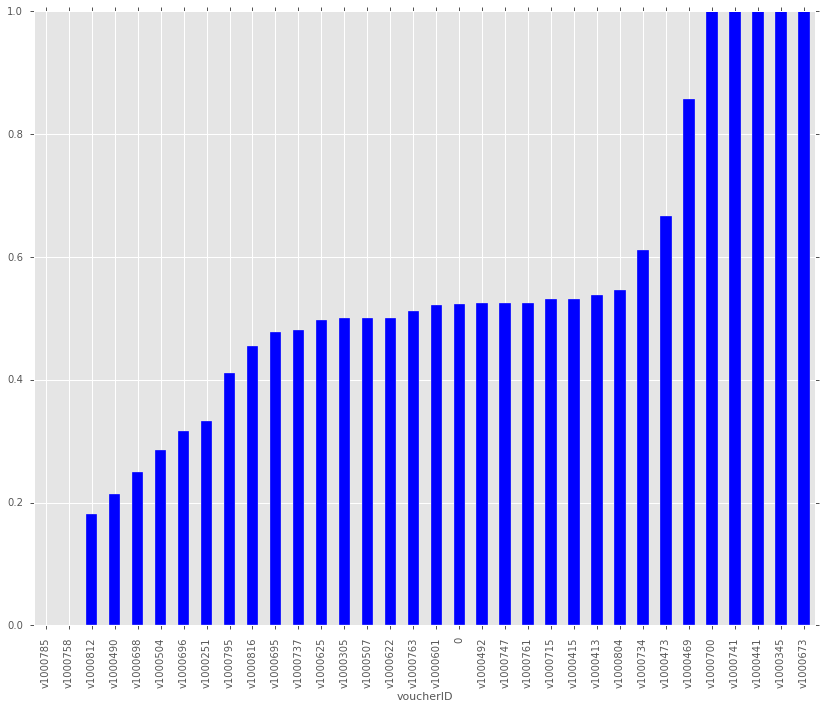

In [26]:
returned_articles = dft[dft.voucherID.isin(knownVoucher)].groupby(['voucherID']).returnQuantity.sum()
bought_articles = dft[dft.voucherID.isin(knownVoucher)].groupby(['voucherID']).quantity.sum()
voucher_return_probs = returned_articles / bought_articles
axes = voucher_return_probs.sort_values().plot('bar')
axes.set_ylim([0,1])

In [55]:
summedVoucher = dfc[dfc.voucherID.isin(knownVoucher)].groupby(['voucherID']).agg('count')
summedVoucher.orderID

voucherID
0           247246
v1000251         1
v1000305         1
v1000345         3
v1000413        35
v1000415      9150
v1000441         1
v1000469         2
v1000473         1
v1000490        21
v1000492        58
v1000504         4
v1000507         8
v1000601        13
v1000622         1
v1000625       284
v1000673         3
v1000695       388
v1000696        38
v1000698         2
v1000700         2
v1000715        46
v1000734      2100
v1000737       330
v1000741         2
v1000747      3245
v1000758         2
v1000761         3
v1000763      1463
v1000785         2
v1000795      1595
v1000804      2008
v1000812        20
v1000816       382
Name: orderID, dtype: int64

1. _articleID_ might be interesting compared to _productGroup_ (are there articles which we can just add to a previously known productGroup? if it is unkown?). For _productGroup_ this is interesting because we may find a similar productGroup we can get the returnProbability from.
2. _colorCode_ might be mappable and probably we can use bins that contain old and new colors in order to make a semantic split with regard to returnQuantity.
3. _voucherID_ is an extremely risky feature since we only know 20% of the occurring vouchers in our target set. Thus we should teadiously reason why we want to keep that feature or if we want to.
4. _customerID_ shows us that we can learn more about customers and it pays out for 70%. Also we should learn about first-time customer behavior in order to classify the other 30% better.

## Strategy for training with respect to the target set
1. New articles lead to new productGroups. But there are also new articles which belong to old productGroups which might contain information regarding returns. So both features lead to specific classifiers. We can have one that deals with known articles and productGroups (biggest set), known articles and unknown pG, unknown articles and unknown pG, and both unknown
2. colorCode can be binned as the latest tickets show. There are some outliers which seem to be bugs and can be transformed to the usual color codes. Further we can then bin those colors to similar colors since they have an equal return probability. It turns out that deviation per bin stays small when using 1k bins.
3. voucherID as can be seen in the above plot and list of values is not neglectable when classifying on return. It might make sense to classify those rows containing voucherIDs at the borders specially instead of having a specialized classifier.
4. customerID is time variant and thus we have to separate those customers which we don't know from the unknown ones. This leads to the third binary switch meaning that we have an array of three binary indicators saying if we know about this feature or not from the past, namely: $ (articleID, productGroup, customerID)$

## Quantitative analysis of missing features in target set
$(articleID, productGroup, customerID, voucherID)$

In [69]:
kArticle, ukArticle = diff('articleID')
kProdG, ukProdG = diff('productGroup')
kCustomer, ukCustomer = diff('customerID')
kVoucher, ukVoucher = diff('voucherID')

In [62]:
len(dfc[dfc.articleID.isin(ukArticle)][dfc.productGroup.isin(ukProdG)][dfc.customerID])

0

In [73]:
len(dfc[dfc.articleID.isin(ukArticle)][dfc.productGroup.isin(ukProdG)][dfc.productGroup])

107387

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
341068    False
341069    False
341070    False
341071    False
341072    False
341073    False
341074    False
341075    False
341076    False
341077    False
341078    False
341079    False
341080    False
341081    False
341082    False
341083    False
341084    False
341085    False
341086    False
341087    False
341088    False
341089    False
341090    False
341091    False
341092    False
341093    False
341094    False
341095    False
341096    False
341097    False
Name: articleID, dtype: 